# Simulation du mouvement brownien multi-fractionnaire

A _fractional Brownian motion_ (fBm) is characterized by a parameter $H∈(0,1)$, the _Hurst exponent_, whose value indicates different properties of the process:
- if $H = 1/2$, the fBm is identical to a standard Brownian motion  or Wiener process,
- if $H > 1/2$, the increments are positively correlated (persistent),
- if $H < 1/2$, the increments are negatively correlated (anti-persistent).

As a consequence, if we estimate a Hurst exponent $H \neq 1/2$, then the evolution of the log-prices is in part predictable and arbitrages may occur.

If the Hurst exponent is time-dependent, the resulting process
is then called a _multifractional Brownian motion_ (mBm).

A fBm $B_H$, of Hurst exponent $H$ and volatility scale parameter $\sigma^2$, is defined as the only centred Gaussian process with zero at the origin and with the following covariance function, for $s, t \geq 0$:
$$E[B_{H}(t)B_{H}(s)] = \frac{\sigma^{2}}{2}(|t|^{2H} + |s|^{2H} − |t − s|^{2H})$$
Increments of $B_H$ of duration $\tau$ are thus stationary: they follow a centred Gaussian distribution of variance $\sigma^{2}|\tau|^{2H}$. If $H = 1/2$, it corresponds to the standard Brownian motion, whose increments have a variance $\sigma^{2}|\tau|$. The increments are positively correlated if $H > 1/2$ and negatively correlated if $H < 1/2$, while they are independent for $H = 1/2$.

For a mBm $X$, the covariance function becomes, for $s, t ∈ [0, 1]$:
$$E[X_{t}X_{s}] = \frac{\sigma^{2}}{2}\cdot g(H_{t},H_{s})\cdot (|t|^{H_{t}+H_{s}} + |s|^{H_{t}+H_{s}} −|t−s|^{H_{t}+H_{s}})$$
where
$$g(H_{t}, H_{s}) = \frac{\sqrt{K(2H_{t})K(2H_{s})}}{K(H_{t}+H_{s})}$$
and
$$K(\alpha) = \Gamma(1 + \alpha)\frac{\sin(\alpha \pi/2)}{\pi}$$
For $s$ and $t$ such that $H_{t} = H_{s}$, we have $g(H_{t}, H_{s}) = 1$ and the covariance is equal to the one of a fBm.

In [1]:
import numpy as np
import pandas as pd
from fbm import FBM, times, fbm, fgn
from mbm import MBM, mbm, mgn
import matplotlib.pyplot as plt
import time
import math

# The following allows to save plots in SVG format.
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

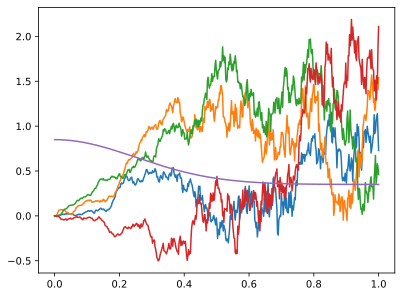

In [2]:
def h(t):
    # return 0.499*math.sin(t) + 0.5
    # return 0.6 * t + 0.3
    return 0.5 * math.exp(-8 * t ** 2) + 0.35


m = MBM(513, h, 1)
#m = MBM(1024, h, 1)
t = m.times()
mb = m.mbm()

plt.plot(t, mb)
plt.plot(t, m.mbm())
plt.plot(t, m.mbm())
plt.plot(t, m.mbm())
plt.plot(t, [h(tt) for tt in t])
plt.show()


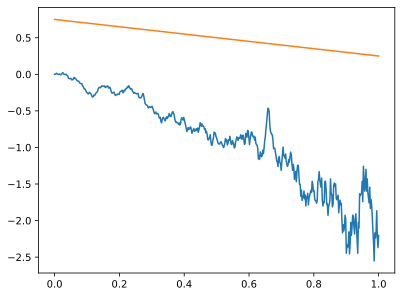

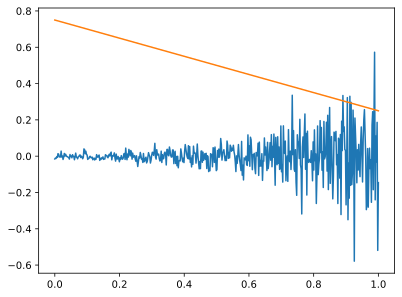

In [19]:
# Define a hurst function
def h(t):
    return 0.75 - 0.5 * t

N = 512

# Generate a mbm realization
mbm_sample = mbm(n=N, hurst=h, length=1, method='riemannliouville')
# Get the times associated with the mBm
t = times(n=N, length=1)

plt.plot(t, mbm_sample)
plt.plot(t, [h(tt) for tt in t])
plt.show()

# Generate a mGn realization
mgn_sample = mgn(n=N, hurst=h, length=1, method='riemannliouville')
# Get the times associated with the mGn
t = times(n=N-1, length=1)

plt.plot(t, mgn_sample)
plt.plot(t, [h(tt) for tt in t])
plt.show()


## Generate random price histories
based on time-dependent Hurst exponent estimated from the histprical price of an instrument

In [11]:
# Estimation
def calculate_M(k, epsilon, s_aff):
    M = np.zeros((len(s_aff), 1))
    for tt in range(0, len(s_aff)):
        if tt < epsilon: 
            n = 0
        else : 
            n = tt - (epsilon-1)
        sum = 0.0    
        for i in range(n + 1, tt+1):
            sum = sum + np.power(abs(s_aff[i] - s_aff[i-1]) , k)  
            if tt < epsilon: 
                M[tt] = sum /tt 
            else:
                M[tt] = sum / (tt - n + 1)
    return M
def calculate_M_bis(k, epsilon, s_aff):
    M_bis = np.zeros((len(s_aff), 1))
    for tt in range(0, len(s_aff)):        
        if tt < epsilon: 
            n = 0
        else : 
            n = tt - (epsilon-1)
        sum = 0.0    
        for i in range(n+1, tt+1,2):
            if tt < epsilon: 
                if i>2:
                    sum = sum + np.power(abs(s_aff[i] - s_aff[i-2]) , k)  # moment 2
                else:
                    sum = sum + np.power(abs(s_aff[i]) , k)
                M_bis[tt] = 2*sum /tt
            else:
                sum = sum + np.power(abs(s_aff[i] - s_aff[i-2]) , k) 
                M_bis[tt] = 2*sum / (tt - n + 1)
    return M_bis
def calculate_H_estimated(k, epsilon, s_aff):
    M = calculate_M(k, epsilon, s_aff)
    M_bis = calculate_M_bis(k, epsilon, s_aff)
    H_estimated = 0.5 * np.log2(M_bis[1:]/M[1:])
    H_estimated = np.minimum(H_estimated, 0.9999)
    H_estimated = np.maximum(H_estimated, 0.0001)
    ct = H_estimated[42]
    H_estimated = np.insert(H_estimated, 0, ct)    
    return H_estimated
LAMBDA = 0.02
def calculate_phi_H_estimated(param_lambda, H_estimated, t_aff):
    phi_H_estimated =  np.zeros((len(t_aff), 1))
    param = np.sqrt(param_lambda)
    for i in range(0, len(t_aff)):
        sum1 = 0.0
        sum2 = 0.0
        for j in range(0,i+1):
            if j == 0: # case V0
                Vj = (t_aff[1] - t_aff[0] ) / 2
            elif j == len(t_aff) - 1 : #case j = N (199)
                Vj = (t_aff[j] - t_aff[j - 1] ) / 2
            else : 
                Vj = (t_aff[j + 1] - t_aff[j - 1] ) / 2
            sum1 = sum1 + np.exp(-t_aff[j] / param) * H_estimated[j] * Vj
            sum2 = sum2 + np.exp(t_aff[j] / param) * H_estimated[j] * Vj
        phi_H_estimated[i] = (-np.exp(t_aff[i]/param) / (2*param)) * sum1 + (+np.exp(-t_aff[i]/param) / (2*param)) * sum2
    return phi_H_estimated
def calculate_alpha(t_aff, param_lambda, start_window=0, n_window=None):
    if n_window is None: n_window = len(t_aff)
    param = np.sqrt(param_lambda)
    sum1 = 0.0
    sum2 = 0.0
    for i in range(start_window+1, n_window):
        sum1 = sum1 + np.exp(2*t_aff[i]/param)
        sum2 = sum2 + np.exp(-2*t_aff[i]/param)
    alpha = sum1 * sum2 - np.square((n_window - start_window) - 1) 
    return alpha
def calculate_A_B(t_aff, param_lambda, H_estimated, phi_H_estimated, start_window=0, n_window=None):
    if n_window is None: n_window = len(t_aff)
    sumA_1 = 0.0
    sumA_2 = 0.0
    sum2 = 0.0
    sum1 = 0.0
    alpha = calculate_alpha(t_aff, param_lambda, start_window, n_window)
    param = np.sqrt(param_lambda)
    for i in range(start_window+1, n_window):
        sumA_1 = sumA_1 + (np.exp(t_aff[i]/param) * (H_estimated[i] -phi_H_estimated[i] ))
        sumA_2 = sumA_2 + (np.exp( - t_aff[i]/param) * (H_estimated[i] -phi_H_estimated[i] ))
        sum1 = sum1 + np.exp(2*t_aff[i]/param)
        sum2 = sum2 + np.exp(-2*t_aff[i]/param)        
    A = (1/alpha) * ( sum2 * sumA_1 - ((n_window - start_window - 1 ) * sumA_2)) 
    B = (1/alpha) * ( sum1 * sumA_2 - ((n_window - start_window - 1 ) * sumA_1))     
    return A, B
def calculate_H_smoothed(t_aff, param_lambda, H_estimated, phi_H_estimated, start_window=0, n_window=None):
    if n_window is None: n_window = len(t_aff)
    A, B = calculate_A_B(t_aff, param_lambda, H_estimated, phi_H_estimated, start_window, n_window)  
    param = np.sqrt(param_lambda)
    H_smoothed_discretized =  np.zeros((n_window - start_window, 1))
    for i in range(start_window, n_window):
        H_smoothed_discretized[i - start_window] = phi_H_estimated[i] + A*np.exp(t_aff[i]/param) + B*np.exp(-t_aff[i]/param)        
    return H_smoothed_discretized

# Reading CSV
def read_index_csv(csv_path):
    print('reading: ', csv_path)
    date = 'Date'    
    input = pd.read_csv(csv_path, decimal='.', delimiter=';', parse_dates=[date], date_format='%Y/%m/%d', dtype={'Value': float})
    input[date] = pd.to_datetime(input[date])
    input[date] = input[date].dt.date
    input = input.sort_values(by=[date])
    input['Value'] = input['Value'].astype('float64')
    input.set_index(date, inplace=False)
    return input

reading:  MSGTMENE-F000010CAO.csv


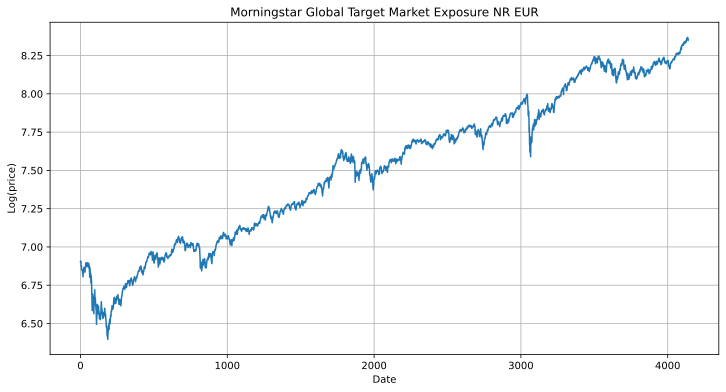

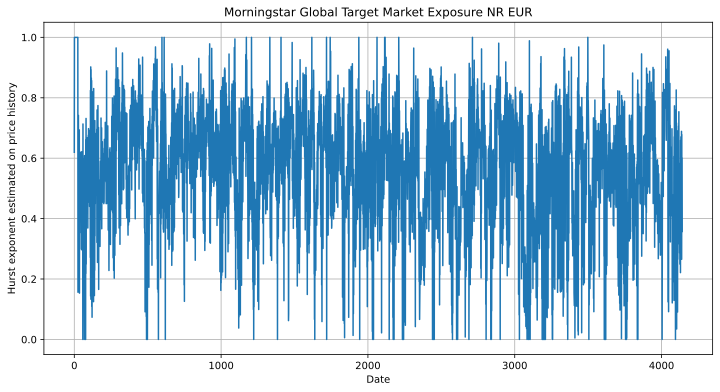

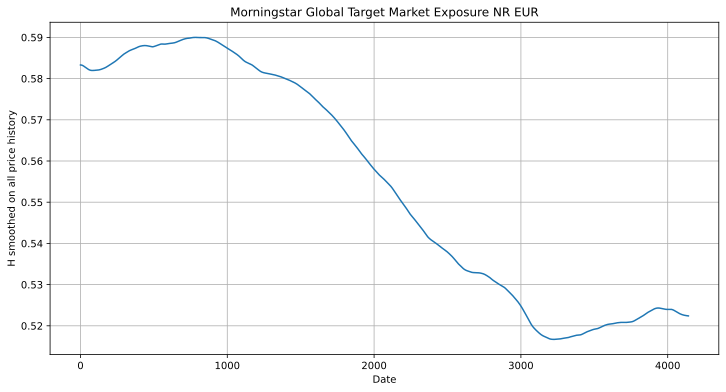

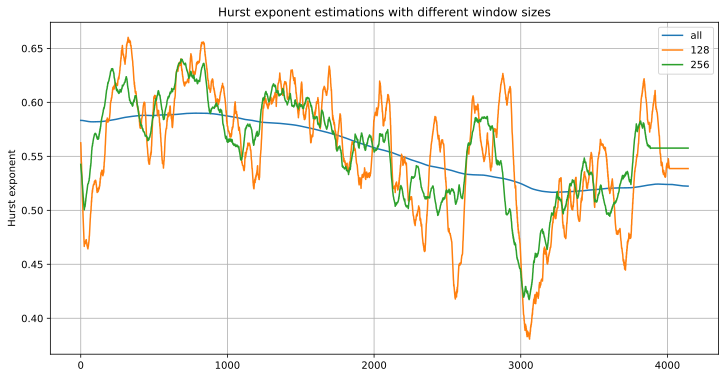

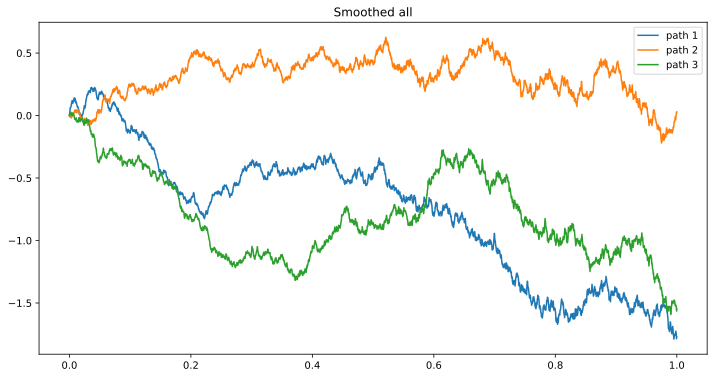

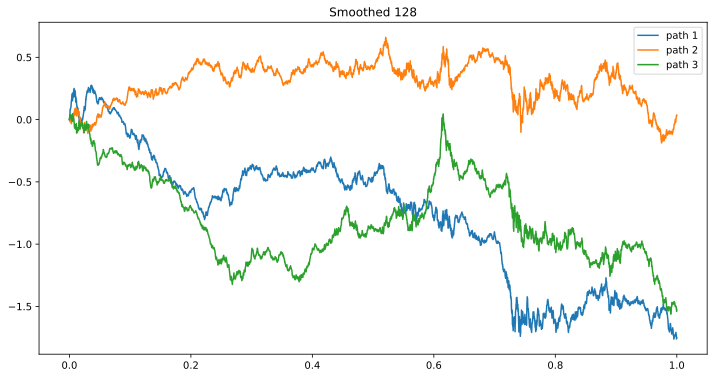

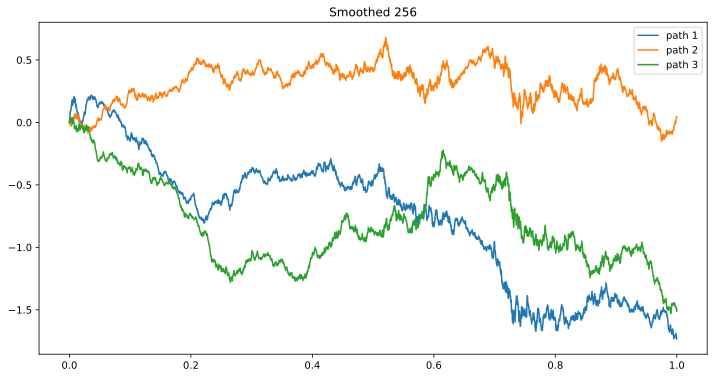

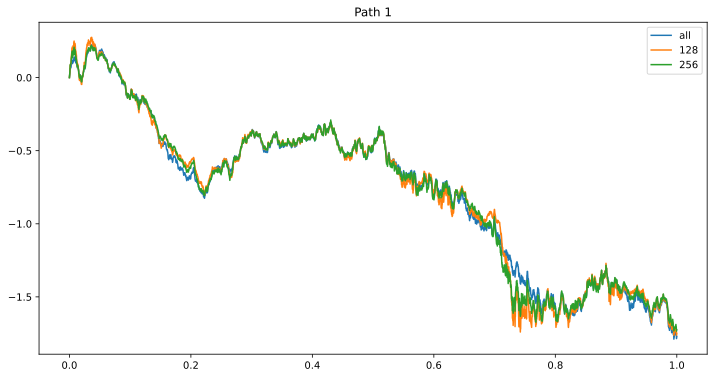

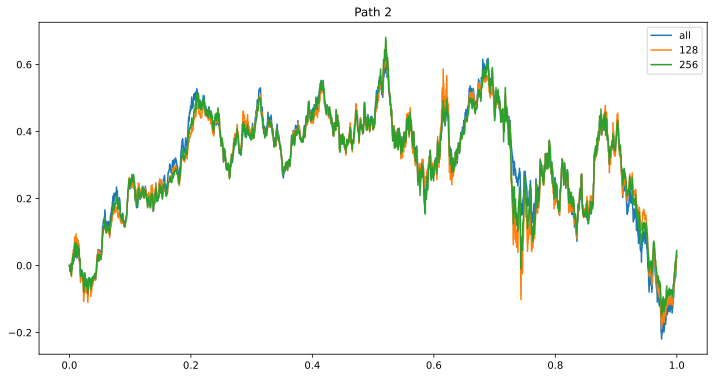

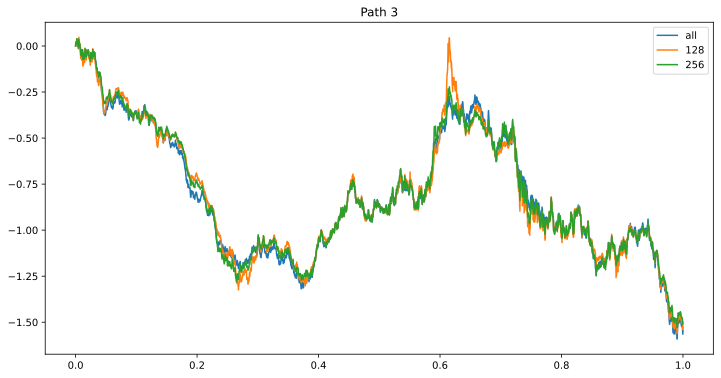

In [23]:
def plot_value(input, value_col, value_label, title):
    plt.figure(figsize=(12, 6))
    input[value_col].plot()
    plt.xlabel('Date'),plt.ylabel(value_label) 
    plt.title(title)
    plt.grid()
    plt.show()

# https://indexes.morningstar.com/our-indexes/details/morningstar-global-target-market-exposure-FS0000DQH7?currency=EUR&variant=NR&tab=overview
# mnemonic: MSGTMENE
# msid: F000010CAO
SERIES_NAME = 'Morningstar Global Target Market Exposure NR EUR'
df = read_index_csv('MSGTMENE-F000010CAO.csv')
n_obs = len(df)
t_interval = np.linspace(0, 1, n_obs)
df['T'] = t_interval
df['LogValue'] = np.log(df['Value'])
#df['Return'] = df['Value'].pct_change()
#df['LogReturn'] = df['LogValue'].pct_change()
#plot_value(df, 'Value', 'Price', SERIES_NAME)
plot_value(df, 'LogValue', 'Log(price)', SERIES_NAME)
#plot_value(df, 'Return', 'Return', SERIES_NAME)
#plot_value(df, 'LogReturn', 'Return of log(price)', SERIES_NAME)

df['H estimated'] = calculate_H_estimated(2, 25, df['LogValue'].values)
plot_value(df, 'H estimated', 'Hurst exponent estimated on price history', SERIES_NAME)
df['phi H estimated'] = calculate_phi_H_estimated(LAMBDA, df['H estimated'].values, t_interval)
#plot_value(df, 'phi H estimated', 'phi H estimated on price', SERIES_NAME)
df['H smoothed all'] = calculate_H_smoothed(t_interval, LAMBDA,
    df['H estimated'].values, df['phi H estimated'].values, n_window= n_obs).ravel()
plot_value(df, 'H smoothed all', 'H smoothed on all price history', SERIES_NAME)

#W_arr = [32, 64, 128, 256, 512]
W_arr = [128, 256]
for W in W_arr:
    arr = np.array([])
    for i in range(0, n_obs-W):
        w = calculate_H_smoothed(t_interval, LAMBDA,
            df['H estimated'].values, df['phi H estimated'].values, start_window=i, n_window=W+i).ravel()
        arr = np.append(arr, [np.median(w)])
        #arr = np.append(arr, [np.mean(w)])
    v = arr[-1]
    for i in range(0, W):
        arr = np.append(arr, [v])
    df['H smoothed '+str(W)] = arr
    #plot_value(df, 'H smoothed '+str(W), 'H smoothed on '+str(W), SERIES_NAME)

plt.figure(figsize=(12, 6))
plt.plot(df['H smoothed all'])
for W in W_arr:
    plt.plot(df['H smoothed '+str(W)])
plt.title('Hurst exponent estimations with different window sizes')
plt.ylabel('Hurst exponent')
plt.grid()
legend = ['all']
for W in W_arr:
    legend.append(str(W))
plt.legend(legend, loc='best')
plt.show()

def h_all(t):
    return df.iloc[(df['T']-t).abs().argsort()[:1]]['H smoothed all'].values[0]
def h_128(t):
    return df.iloc[(df['T']-t).abs().argsort()[:1]]['H smoothed 128'].values[0]
def h_256(t):
    return df.iloc[(df['T']-t).abs().argsort()[:1]]['H smoothed 256'].values[0]

#m = MBM(n_obs, h_all, 1)
#t = m.times()
#plt.figure(figsize=(12, 6))
#plt.ylabel('Hurst exponent')
#plt.plot(t, [h_all(tt) for tt in t])
#plt.plot(t, [h_128(tt) for tt in t])
#plt.plot(t, [h_256(tt) for tt in t])
#plt.grid()
#plt.legend(['all', '123', '256'], loc='best')
#plt.show()

np.random.seed(0)
m = MBM(n_obs, h_all, 1)
t = m.times()
m_all_1 = m.mbm()
m_all_2 = m.mbm()
m_all_3 = m.mbm()

np.random.seed(0)
m = MBM(n_obs, h_128, 1)
m_128_1 = m.mbm()
m_128_2 = m.mbm()
m_128_3 = m.mbm()

np.random.seed(0)
m = MBM(n_obs, h_256, 1)
m_256_1 = m.mbm()
m_256_2 = m.mbm()
m_256_3 = m.mbm()

plt.figure(figsize=(12, 6))
plt.title('Smoothed all')
plt.plot(t, m_all_1)
plt.plot(t, m_all_2)
plt.plot(t, m_all_3)
plt.legend(['path 1', 'path 2', 'path 3'], loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Smoothed 128')
plt.plot(t, m_128_1)
plt.plot(t, m_128_2)
plt.plot(t, m_128_3)
plt.legend(['path 1', 'path 2', 'path 3'], loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Smoothed 256')
plt.plot(t, m_256_1)
plt.plot(t, m_256_2)
plt.plot(t, m_256_3)
plt.legend(['path 1', 'path 2', 'path 3'], loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Path 1')
plt.plot(t, m_all_1)
plt.plot(t, m_128_1)
plt.plot(t, m_256_1)
plt.legend(['all', '128', '256'], loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Path 2')
plt.plot(t, m_all_2)
plt.plot(t, m_128_2)
plt.plot(t, m_256_2)
plt.legend(['all', '128', '256'], loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Path 3')
plt.plot(t, m_all_3)
plt.plot(t, m_128_3)
plt.plot(t, m_256_3)
plt.legend(['all', '128', '256'], loc='best')
plt.show()
